In [1]:
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import collections
import functools
from IPython import display
import itertools
from time import sleep

# Model Cancer spread with intervention
Four Effective States - Normal(1), Cancer(2), Reproducing_Cancer(3), Dead(4), Empty(0)
Assumptions: 
 1) Normal Cells turn to Cancer due to mutation every t_NC steps.\
 2) Normal Cells do not reproduce.\
 3) All Cells die at same rate.\
 4) Cancer Cells turn Reproducing_Cancer after n steps.\
 5) Reproducing Cancer reproduce to Cancer with every m steps to k neighbor cells\
 7) Dead cells get removed from grid every l steps\
 8) Moore neighborhood assumed. New RC cells replace live cells.\
 9) Boundary Condition is fixed.


In [12]:
# helper functions
def get_left(position,r):
    i,j = position
    return [i-r, j]

def get_right(position,r):
    i,j = position
    return [i+r, j]

def get_top(position, r):
    i,j = position
    return [i, j+r]

def get_bottom(position, r):
    i,j = position
    return [i, j-r]

def get_top_right(position, r):
    i,j = position
    return [i+r, j+r]

def get_top_left(position, r):
    i,j = position
    return [i-r, j+r]

def get_bottom_right(position,r):
    i,j = position
    return [i+r,j-r]

def get_bottom_left(position,r):
    i,j = position
    return [i-r,j-r]

def check_valid_rates(cancer_reproduction, death_rate, 
                      incubation_period, dead_cell_removal_rate, probability_rate,
                      intervention, num_steps):
    # some assumptions
    assert cancer_reproduction["period"] > 0
    assert cancer_reproduction["num_cells"] > 0
    assert cancer_reproduction["num_cells"] < 8
    assert probability_rate["cancer_death"] >= 0
    assert probability_rate["cancer_death"] <= 1
    assert probability_rate["reproduction_death"] >= 0
    assert probability_rate["reproduction_death"] <= 1
    assert intervention["period"] > 0
    assert intervention["grid_size"] > 0
    assert intervention["grid_size"] < num_steps
    assert incubation_period > 0
    assert death_rate > 0
    assert dead_cell_removal_rate > 0   

In [3]:
# l1 = [i for i in range(10)]
# l2 = [i for i in range(10)]
# grid_positions = list(itertools.product(l1, l2))
# print(grid_positions)

In [ ]:
class CA:
    def __init__(self, x, cancer_reproduction, 
                 death_rate, incubation_period, 
                 dead_cell_removal_rate, probability_rates,intervention):
        self.grid = np.zeros((x,x),dtype = int)
        self.x = x # grid size
        self.cancer_reproduction= {"period": cancer_reproduction["period"],
                                  "num_cells":cancer_reproduction["num_cells"]}
        self.death_rate = death_rate
        self.incubation_period = incubation_period
        self.dead_cell_removal_rate = dead_cell_removal_rate
        self.intervention = {"period":intervention["period"],
                                   "grid_size":intervention["grid_size"]}
        self.probability_rates = {"cancer_death":probability_rates["cancer_death"],
                                 "reproduction_death": probability_rates["cancer_death"]}
        self.num_steps = 0
        
        
    def initialize_grid(self, num_steps, num_cancer_cells):
        self.grid[:][:] = 1 # all Normal Cells
        all_positions = self.get_grid_positions()
        cancer_positions = random.sample(all_positions, num_cancer_cells)
        for position in cancer_positions:
            self.grid[position[0]][position[1]] = 2 # Cancer
        self.num_steps = num_steps
        
    def get_grid_positions(self):
        l1 = [i for i in range(self.x)]
        l2 = [i for i in range(self.x)]
        return list(itertools.product(l1, l2))
    
    # fixed boundary condition
    def get_moore_neighbours(self, grid_position):
        positions = []
        i,j = grid_position
        max_dim = len(self.grid) - 1
        r = 1
        if i > 0 and i < max_dim and j > 0 and j < max_dim:
            positions = [get_top(grid_position, r),get_bottom(grid_position,r),
                         get_left(grid_position,r),get_right(grid_position,r),
                        get_top_right(grid_position,r), get_top_left(grid_position,r),
                        get_bottom_right(grid_position,r), get_bottom_left(grid_position,r)]
        elif i == 0 and j == 0: 
            positions = [get_top(grid_position, r), get_right(grid_position,r),
                        get_top_right(grid_position,r)]
        elif i == 0 and (j > 0 and j < max_dim): 
            positions = [get_bottom(grid_position, r), get_right(grid_position,r),get_bottom_right(grid_position,r),
                        get_top(grid_position, r), get_top_right(grid_position,r)]
        elif i == 0 and j == max_dim:
            positions = [get_bottom(grid_position, r), get_bottom_right(grid_position,r),
                        get_right(grid_position,r)]
        elif (i > 0 and i < max_dim) and j == 0:
            positions = [get_top(grid_position, r), get_left(grid_position,r),
                        get_top_left(grid_position,r), get_right(grid_position,r), get_top_right(grid_position,r)]
        elif i == max_dim and j == 0:
            positions = [get_top(grid_position, r), get_left(grid_position,r), get_top_left(grid_position,r)]
        else: # (max_dim, max_dim)
            positions = [get_bottom(grid_position, r), get_left(grid_position,r), get_bottom_left(grid_position,r)]
            
        return positions
    
    def print_params(self):
        print("Cancer reproduction n_Cells = "+str(self.cancer_reproduction["num_cells"]))
        print("Cancer reproduction period = "+str(self.cancer_reproduction["period"]))
        print("Death rate = "+str(self.death_rate))
        print("Conversion rates Normal to Cancer = "+str(self.conversion_rates["N_to_C"]))
        print("Conversion rates Cancer to Reproducing Cancer = "+str(self.conversion_rates["C_to_RC"]))
        print("Dead Cells removal rate = "+str(self.dead_cell_removal_rate))
        
    def update(self, step):
        if step <= self.num_steps:
            for position in self.get_grid_positions():
                # update cancer cells
                if self.grid[position[0]][position[1]] == 2: # Cancer
                    # check current time step == reproductive cancer conversion rate
                    if (step % self.incubation_period == 0):
                        self.grid[position[0]][position[1]] = 3 # Turn to Reproductive Cancer cells
                    if (step % self.death_rate == 0):
                        die = random.uniform(0,1)
                        if (die < self.probability_rates["cancer_death"]):
                            self.grid[position[0]][position[1]] = 4
                # update_ reproductive_cancer_cells
                elif self.grid[position[0]][position[1]] == 3:
                    # check current time step == period of cancer reproduction
                    if (step % self.intervention["period"] == 0):
                        n = position[0] + self.intervention["grid_size"]
                        m = position[1] + self.intervention["grid_size"]
                        self.grid[position[0]:n][position[1]:m] = 1
                    if (step % self.cancer_reproduction["period"] == 0):
                        neighbors = self.get_moore_neighbours(position)
                        converted_neighbors = random.sample(neighbors, self.cancer_reproduction["num_cells"])
                        for neighbor in converted_neighbors:
                            if self.grid[neighbor[0]][neighbor[1]] != 3:
                                self.grid[neighbor[0]][neighbor[1]] = 3
                        
                    elif (step % self.death_rate == 0):
                        die = random.uniform(0,1)
                        if (die < self.probability_rates["reproduction_death"]):
                            self.grid[position[0]][position[1]] = 4
                # update dead cells   
                elif self.grid[position[0]][position[1]] == 4:
                    # check current time step == dead_removal_rate
                    if (step % self.dead_cell_removal_rate == 0):
                        self.grid[position[0]][position[1]] = 0 # Empty
                else:
                    # replace empty cells with new cells.
                    self.grid[position[0]][position[1]] = 1 # Normal
        return self.grid
                
    def print_grid(self):
        print(self.grid)

In [ ]:
# # # Test moore neighbors
# ca_test = CA(grid_size, cancer_reproduction, death_rate, conversion_rates, dead_cell_removal_rate) 
# ca_test.initialize_grid(num_steps)
# # ca_test.print_grid()
# # test 1
# position = (0,0)
# positions = ca_test.get_moore_neighbours(position)
# valid_positions = [[0,1],[1,1],[1,0]]
# assert sorted(positions) == sorted(valid_positions), print("positions = ", positions)
# # test 2
# position = (9,9)
# positions = ca_test.get_moore_neighbours(position)
# valid_positions = [[9,8],[8,8],[8,9]]
# assert sorted(positions) == sorted(valid_positions), print("positions = ", positions)
# # test 3
# position = (0,9)
# positions = ca_test.get_moore_neighbours(position)
# valid_positions = [[0,8],[1,9],[1,8]]
# assert sorted(positions) == sorted(valid_positions), print("positions = ", positions)
# # test 4
# position = (9,0)
# positions = ca_test.get_moore_neighbours(position)
# valid_positions = [[9,1],[8,0],[8,1]]
# assert sorted(positions) == sorted(valid_positions), print("positions = ", positions)

In [ ]:
# Setup Parameters
cancer_reproduction = {"period": 5,
                       "num_cells": 1}
intervention = {"period": 20,
                "grid_size": 40}

probability_rates = {"cancer_death": 0.9,
                    "reproduction_death": 0.9}
death_rate = 70
incubation_period = 10
dead_cell_removal_rate = 200

num_steps = 1000
check_valid_rates(cancer_reproduction, death_rate, 
                      incubation_period, dead_cell_removal_rate, probability_rates,
                      intervention, num_steps)
grid_size = 100

KeyboardInterrupt: 

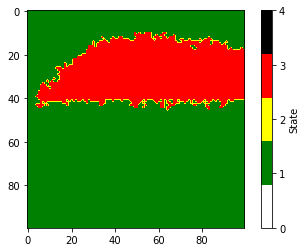

In [48]:
# init CA
from matplotlib import colors
ca = CA(grid_size, cancer_reproduction, 
                 death_rate, incubation_period, 
                 dead_cell_removal_rate, probability_rates,intervention)
num_steps = 1000
num_cancer_cells = 1
ca.initialize_grid(num_steps, num_cancer_cells)
cmap = colors.ListedColormap(["white", "green", 'yellow', "red", "black"])
grid = ca.update(1)
plt.imshow(grid, cmap=cmap, vmin = 0, vmax = 4)
plt.colorbar(ticks=[1,2,3,4,0], label='State')
for step in range(2,num_steps):
    grid = ca.update(step)
    plt.cla()
    plt.imshow(grid, cmap=cmap, vmin = 0, vmax = 4)
    display.display(plt.gcf())
    display.clear_output(wait=True)
    sleep(0.025)
